In [ ]:
# Install a conda package in the current Jupyter kernel
#import sys
#!conda install --yes --prefix {sys.prefix} PyWavelets

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import fftpack
from scipy import signal
import pywt
from skimage.restoration import denoise_wavelet
import scipy.linalg as la

In [2]:
#Load dataset
file_name="center_sternum.txt"
data=pd.read_csv(file_name, "\t")

C:\Users\enric\AppData\Local\Temp\ipykernel_14852\799181514.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data=pd.read_csv(file_name, "\t")


In [3]:
#Get sampling frequency and add absolute time column 
freqs = data["Log Freq"].unique()
freq = np.bincount(freqs).argmax()
dt = 1.0/freq
data["Abs Time"] = np.arange(0, len(data)*dt, dt)

#initial_time=data.loc[0, "Timestamp"]
#data["Abs Time"] = np.zeros(len(data))
#for value, table in data.groupby("Timestamp"):
#    data.loc[data["Timestamp"] == value, "Abs Time"] = value - initial_time + np.arange(0, len(table),1)/len(table)

In [4]:
#Calibrate device readings (with offset)

cal_Acc = cal_Magn = np.zeros((3,3))
off_Gyro = off_Acc = off_Mag = np.zeros((1,3))

if file_name == "center_sternum.txt":
    cal_Acc  = np.array([[ 1.000966,     -0.002326418, -0.0006995499],
                         [-0.002326379,   0.9787045,   -0.001540918 ],
                         [-0.0006995811, -0.001540928,  1.00403     ]])
    cal_Magn = np.array([[ 0.9192851,    -0.02325168,   0.003480837],
                         [-0.02325175,    0.914876,     0.004257396],
                         [ 0.003481006,   0.004257583,  0.8748001  ]])
    
    off_Acc  = np.array( [ -3.929942, -13.74679,  60.67546 ])
    off_Gyro = np.array( [ -2.242224,   2.963463, -0.718397])
    off_Magn = np.array( [-95.67974, -244.9142,   17.71132 ])
    
else:
    cal_Acc  = np.array([[ 1.002982,     9.415505E-05, 0.004346743],
                         [ 9.04459E-05,  1.002731,    -0.001444198],
                         [ 0.004346536, -0.001444751,  1.030587   ]])
    cal_Magn = np.array([[ 1.013437,    -0.04728858,  -0.001861475],
                         [-0.04728862,   1.004832,     0.008222118],
                         [-0.001861605,  0.008221965,  0.9439077  ]])
    
    off_Acc  = np.array( [   3.602701, -20.96658,  54.97186  ])
    off_Gyro = np.array( [  -2.804399,   1.793105,  0.3411708])
    off_Magn = np.array( [-150.4098,    74.62431, 630.9805   ])


data[['AccX', 'AccY', 'AccZ' ]] = np.dot(data[['AccX','AccY','AccZ']], cal_Acc.T) + off_Acc.T
data[['GyroX','GyroY','GyroZ']] = data[['GyroX','GyroY','GyroZ']] + off_Gyro.T
data[['MagnX','MagnY','MagnZ']] = np.dot(data[['MagnX','MagnY','MagnZ']], cal_Magn.T) + off_Magn.T

In [5]:
#Select useful features and drop the others
labels=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagnX", "MagnY", "MagnZ"]
Nvar = len(labels) #number of features to analise
data=data.drop(["Log Mode", "Log Freq", "Timestamp", "qw", "qi", "qj", "qk"], axis=1)

#Look at data
display(data)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
0,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690,0.000
1,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890,0.005
2,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890,0.010
3,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605,0.015
4,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605,0.020
...,...,...,...,...,...,...,...,...,...,...
16501,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764,82.505
16502,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222,82.510
16503,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222,82.515
16504,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388,82.520


In [ ]:
#Plot Gyro and Acc con tutti i crismi

#TO DO

In [6]:
#Select only time window where the signal is not disturbed:
# [10;65] s
t1_cut = 10
t2_cut = 65
data_cut = data.loc[(data["Abs Time"] >= t1_cut) & (data["Abs Time"] <= t2_cut)]
display(data_cut)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
2000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911,10.000
2001,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911,10.005
2002,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964,10.010
2003,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964,10.015
2004,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969,10.020
...,...,...,...,...,...,...,...,...,...,...
12996,-44.203217,102.317144,-892.706502,-3.371995,6.978730,-1.237481,-277.248552,-631.614362,387.814391,64.980
12997,-36.631201,102.001043,-892.711324,-3.356728,6.551249,-1.435954,-277.264842,-630.690971,389.568248,64.985
12998,-28.811253,103.792989,-905.152510,-3.799476,6.902394,-1.359618,-277.264842,-630.690971,389.568248,64.990
12999,-46.173206,104.746772,-877.948746,-3.814743,6.978730,-1.771832,-278.187608,-630.671977,388.689967,64.995


In [ ]:
#THIS BOX IS TO BE ELIMINATED 
#AND SUBSTITUTED WITH THE ONE TWO ABOVE

#plot Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data["Abs Time"], data[labels[j]], label=labels[j])
        if i == 1:
            axs[j][i].set_xlim([20,24])
        
axs[0][1].set_ylim([-10,7])
axs[1][1].set_ylim([0,7])
axs[2][1].set_ylim([-2.5,0.5])
axs[3][1].set_ylim([-60,-0])
axs[4][1].set_ylim([90,130])
axs[5][1].set_ylim([-1015,-885])


for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [7]:
#Get statistical descriptors 
data_statistics = data_cut.describe()
display(data_statistics)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
count,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000
mean,-34.125429,100.654133,-892.862843,-4.319344,6.651708,-1.586729,-278.723389,-633.791766,391.294005,37.500000
std,7.033450,5.224951,14.452377,1.425395,0.717895,0.364948,1.204988,1.564649,2.524112,15.879297
min,-70.523078,71.834825,-959.109087,-12.242224,3.467280,-3.222214,-282.650371,-639.776198,380.808251,10.000000
25%,-38.758325,97.171078,-901.407869,-4.929247,6.245906,-1.832901,-279.865783,-635.178566,389.537294,23.750000
50%,-34.010220,100.808275,-893.309854,-4.394896,6.597051,-1.573359,-278.969750,-633.439856,391.293856,37.500000
75%,-29.448412,104.096712,-885.126901,-3.707873,6.963463,-1.344351,-278.057426,-632.497471,393.908188,51.250000
max,-8.963639,131.953547,-822.777963,2.231058,10.520715,-0.077176,-274.460483,-629.710597,396.544210,65.000000


In [8]:
#Normalise dataset
data_std = data_cut.copy(deep=True)
for l in labels:
    data_std[l]= (data_cut[l]-data_statistics.at["mean",l])/data_statistics.at["std",l]
display(data_std)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Abs Time
2000,-0.293809,-0.449531,-0.294253,2.688971,1.859125,0.162137,-0.110858,-3.824775,0.682975,10.000
2001,1.626694,-0.553115,-1.532275,2.549730,0.710728,-0.590871,-0.110858,-3.824775,0.682975,10.005
2002,0.443915,-0.888839,0.366835,2.110586,0.880862,-0.632707,0.582598,-2.096371,-0.696895,10.010
2003,1.249813,-0.263953,0.607756,2.121296,0.625661,-1.092880,0.582598,-2.096371,-0.696895,10.015
2004,-0.263764,0.535763,1.747774,2.174851,1.412526,-0.339869,-0.127266,-3.237338,1.031239,10.020
...,...,...,...,...,...,...,...,...,...,...
12996,-1.432837,0.318283,0.010818,0.664622,0.455529,0.956980,1.223943,1.391624,-1.378550,64.980
12997,-0.356265,0.257784,0.010484,0.675333,-0.139935,0.413140,1.210424,1.981782,-0.683708,64.985
12998,0.755557,0.600744,-0.850356,0.364719,0.349196,0.622309,1.210424,1.981782,-0.683708,64.990
12999,-1.712926,0.783288,1.031948,0.354008,0.455529,-0.507204,0.444636,1.993922,-1.031665,64.995


PCA

In [12]:
data_std=data_std.drop(["Abs Time"], axis=1)
display(data_std)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,-0.293809,-0.449531,-0.294253,2.688971,1.859125,0.162137,-0.110858,-3.824775,0.682975
2001,1.626694,-0.553115,-1.532275,2.549730,0.710728,-0.590871,-0.110858,-3.824775,0.682975
2002,0.443915,-0.888839,0.366835,2.110586,0.880862,-0.632707,0.582598,-2.096371,-0.696895
2003,1.249813,-0.263953,0.607756,2.121296,0.625661,-1.092880,0.582598,-2.096371,-0.696895
2004,-0.263764,0.535763,1.747774,2.174851,1.412526,-0.339869,-0.127266,-3.237338,1.031239
...,...,...,...,...,...,...,...,...,...
12996,-1.432837,0.318283,0.010818,0.664622,0.455529,0.956980,1.223943,1.391624,-1.378550
12997,-0.356265,0.257784,0.010484,0.675333,-0.139935,0.413140,1.210424,1.981782,-0.683708
12998,0.755557,0.600744,-0.850356,0.364719,0.349196,0.622309,1.210424,1.981782,-0.683708
12999,-1.712926,0.783288,1.031948,0.354008,0.455529,-0.507204,0.444636,1.993922,-1.031665


In [13]:

acc_st = data_std[['AccX', 'AccY', 'AccZ']]
gyro_st = data_std[['GyroX', 'GyroY', 'GyroZ']]
magn_st = data_std[['MagnX', 'MagnY', 'MagnZ']]

l_acc, v_acc = la.eig(np.cov(acc_st.T))
l_acc_sum = np.sum(l_acc)
acc_var_ratios = np.array([x / l_acc_sum for x in l_acc])
print('Acc variability ratios:\n', np.sort(acc_var_ratios * 100))
print('Acc eigenvalues:\n', l_acc[np.argsort(acc_var_ratios)])
print('Acc eigenvectors:\n', v_acc[np.argsort(acc_var_ratios)])

l_gyro, v_gyro = la.eig(np.cov(gyro_st.T))
l_gyro_sum = np.sum(l_gyro)
gyro_var_ratios = np.array([x / l_gyro_sum for x in l_gyro])
print('Gyro variability ratios:\n', np.sort(gyro_var_ratios * 100))
print('Gyro eigenvalues:\n', l_gyro[np.argsort(gyro_var_ratios)])
print('Gyro eigenvectors:\n', v_gyro[np.argsort(gyro_var_ratios)])

l_magn, v_magn = la.eig(np.cov(magn_st.T))
l_magn_sum = np.sum(l_magn)
magn_var_ratios = np.array([x / l_magn_sum for x in l_magn])
print('Magn variability ratios:\n', np.sort(magn_var_ratios * 100))
print('Magn eigenvalues:\n', l_gyro[np.argsort(magn_var_ratios)])
print('Magn eigenvectors:\n', v_gyro[np.argsort(magn_var_ratios)])

Acc variability ratios:
 [19.62648034+0.j 29.57358675+0.j 50.7999329 +0.j]
Acc eigenvalues:
 [0.58879441+0.j 0.8872076 +0.j 1.52399799+0.j]
Acc eigenvectors:
 [[ 0.42270878  0.05762829 -0.90443146]
 [ 0.63454103  0.6937098   0.3407703 ]
 [-0.64705098  0.71794547 -0.25666971]]
Gyro variability ratios:
 [18.76590868+0.j 20.9722818 +0.j 60.26180952+0.j]
Gyro eigenvalues:
 [0.56297726+0.j 0.62916845+0.j 1.80785429+0.j]
Gyro eigenvectors:
 [[ 0.580956   -0.50476115  0.63851884]
 [ 0.58895245 -0.28078373 -0.75782287]
 [ 0.56180524  0.81631898  0.13415732]]
Magn variability ratios:
 [ 9.08849408+0.j 28.07895814+0.j 62.83254778+0.j]
Magn eigenvalues:
 [0.56297726+0.j 0.62916845+0.j 1.80785429+0.j]
Magn eigenvectors:
 [[ 0.580956   -0.50476115  0.63851884]
 [ 0.58895245 -0.28078373 -0.75782287]
 [ 0.56180524  0.81631898  0.13415732]]


In [14]:
l, v = la.eig(np.cov(data_std.T))
l_sum = np.sum(l)
var_ratios = np.array([x / l_sum for x in l])
sort_perm = np.argsort(var_ratios)[::-1]
print('Variability ratios:\n', var_ratios[sort_perm] * 100)
print('Eigenvalues:\n', l[sort_perm])
print('Eigenvectors:\n', v.T[sort_perm].T)

Variability ratios:
 [27.53816914+0.j 19.77526792+0.j 15.22166987+0.j  9.7829842 +0.j
  8.20144656+0.j  6.41335264+0.j  5.88597384+0.j  4.4545779 +0.j
  2.72655792+0.j]
Eigenvalues:
 [2.47843522+0.j 1.77977411+0.j 1.36995029+0.j 0.88046858+0.j
 0.73813019+0.j 0.57720174+0.j 0.52973765+0.j 0.40091201+0.j
 0.24539021+0.j]
Eigenvectors:
 [[-0.29074006  0.01974401 -0.64569476  0.098572   -0.02747254  0.01230159
  -0.34317219 -0.60177565  0.08737893]
 [ 0.41870554 -0.08171391 -0.1308165  -0.09943278 -0.73765913  0.28916909
   0.30295133 -0.18622105  0.19181016]
 [ 0.28215621 -0.16074004  0.42941188  0.65524426 -0.00157303 -0.27326886
  -0.08874747 -0.44021387  0.06684462]
 [-0.18288847 -0.51885277 -0.20091055 -0.11375519 -0.18317075 -0.71615573
   0.29849345  0.08756666 -0.02900882]
 [-0.12438543 -0.58095993  0.12826757  0.03678345 -0.25864104  0.24480895
  -0.63861614  0.3001329   0.06686778]
 [-0.14876182 -0.5564582   0.03382233  0.00090676  0.41723075  0.48058403
   0.44911175 -0.2408849

In [15]:
rot_df = pd.DataFrame()
for i in range(len(l)):
    string = 'pc' + str(i+1)
    rot_df[string] = np.dot(v.T[sort_perm][i], data_std.T)
cols = np.array(rot_df.columns.tolist())
print(cols)
display(rot_df)


n_comp = 0
var_sum = 0
perc_soil = .85
i = 0

princ_comp = pd.DataFrame()

while (var_sum <= perc_soil):
    var_sum += np.real(var_ratios[sort_perm][i])
    n_comp += 1
    i += 1

print(f'To keep {int(perc_soil * 100)}% of our data we need {n_comp} of the {len(var_ratios)} principal components')

rot_df = rot_df[cols[:n_comp]]

display(rot_df)

['pc1' 'pc2' 'pc3' 'pc4' 'pc5' 'pc6' 'pc7' 'pc8' 'pc9']


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9
0,-3.075556,-2.073385,1.551214,-1.032853,-1.999107,-1.188960,-0.063026,-0.097827,-1.881813
1,-3.746282,-0.669567,-0.351711,-1.671538,-1.965161,-1.400279,-0.289961,-0.864730,-1.925569
2,-1.207343,-1.271128,0.391013,-0.540482,-0.749130,-1.870588,-0.796296,-0.525106,-1.866481
3,-1.013789,-0.946233,-0.158092,-0.376339,-1.360556,-2.037110,-0.945426,-1.197307,-1.699591
4,-1.782138,-1.655866,2.187564,0.332378,-2.574169,-1.499913,-0.041797,-1.079059,-0.977769
...,...,...,...,...,...,...,...,...,...
10996,1.998269,-1.689538,0.113516,-0.742265,0.879703,-0.077480,0.410980,0.830026,-0.073150
10997,1.729849,-0.939775,-0.676610,-0.604045,0.933004,-0.569931,0.198949,0.304019,0.821172
10998,1.272156,-1.046873,-1.676807,-1.039097,0.668484,0.220875,-0.313444,0.019258,0.978333
10999,2.664714,-0.810806,0.380972,0.510589,-0.011728,-0.630587,0.022865,1.260122,0.538757


To keep 85% of our data we need 6 of the 9 principal components


,pc1,pc2,pc3,pc4,pc5,pc6
0,-3.075556,-2.073385,1.551214,-1.032853,-1.999107,-1.188960
1,-3.746282,-0.669567,-0.351711,-1.671538,-1.965161,-1.400279
2,-1.207343,-1.271128,0.391013,-0.540482,-0.749130,-1.870588
3,-1.013789,-0.946233,-0.158092,-0.376339,-1.360556,-2.037110
4,-1.782138,-1.655866,2.187564,0.332378,-2.574169,-1.499913
...,...,...,...,...,...,...
10996,1.998269,-1.689538,0.113516,-0.742265,0.879703,-0.077480
10997,1.729849,-0.939775,-0.676610,-0.604045,0.933004,-0.569931
10998,1.272156,-1.046873,-1.676807,-1.039097,0.668484,0.220875
10999,2.664714,-0.810806,0.380972,0.510589,-0.011728,-0.630587


In [34]:
rot_df.index= np.arange(2000, 13001,1)
data_std["pc1"] = rot_df["pc1"]
data_std["pc2"] = rot_df["pc2"]
data_std["pc3"] = rot_df["pc3"]
data_std["pc4"] = rot_df["pc4"]
data_std["pc5"] = rot_df["pc5"]
data_std["pc6"] = rot_df["pc6"]
display(data_std)
labels=["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"]
Nvar=len(labels)
data_std["Abs Time"] = data_cut["Abs Time"]

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,pc1,pc2,pc3,pc4,pc5,pc6,Abs Time
2000,-0.293809,-0.449531,-0.294253,2.688971,1.859125,0.162137,-0.110858,-3.824775,0.682975,-3.075556,-2.073385,1.551214,-1.032853,-1.999107,-1.188960,10.000
2001,1.626694,-0.553115,-1.532275,2.549730,0.710728,-0.590871,-0.110858,-3.824775,0.682975,-3.746282,-0.669567,-0.351711,-1.671538,-1.965161,-1.400279,10.005
2002,0.443915,-0.888839,0.366835,2.110586,0.880862,-0.632707,0.582598,-2.096371,-0.696895,-1.207343,-1.271128,0.391013,-0.540482,-0.749130,-1.870588,10.010
2003,1.249813,-0.263953,0.607756,2.121296,0.625661,-1.092880,0.582598,-2.096371,-0.696895,-1.013789,-0.946233,-0.158092,-0.376339,-1.360556,-2.037110,10.015
2004,-0.263764,0.535763,1.747774,2.174851,1.412526,-0.339869,-0.127266,-3.237338,1.031239,-1.782138,-1.655866,2.187564,0.332378,-2.574169,-1.499913,10.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12996,-1.432837,0.318283,0.010818,0.664622,0.455529,0.956980,1.223943,1.391624,-1.378550,1.998269,-1.689538,0.113516,-0.742265,0.879703,-0.077480,64.980
12997,-0.356265,0.257784,0.010484,0.675333,-0.139935,0.413140,1.210424,1.981782,-0.683708,1.729849,-0.939775,-0.676610,-0.604045,0.933004,-0.569931,64.985
12998,0.755557,0.600744,-0.850356,0.364719,0.349196,0.622309,1.210424,1.981782,-0.683708,1.272156,-1.046873,-1.676807,-1.039097,0.668484,0.220875,64.990
12999,-1.712926,0.783288,1.031948,0.354008,0.455529,-0.507204,0.444636,1.993922,-1.031665,2.664714,-0.810806,0.380972,0.510589,-0.011728,-0.630587,64.995


In [35]:
#perform Fourier analysis

sig_fft = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft[i] = fftpack.fft(data_std[labels[i]].values)

power = np.abs(sig_fft)
sample_freq = fftpack.fftfreq(len(data_std), d=dt)

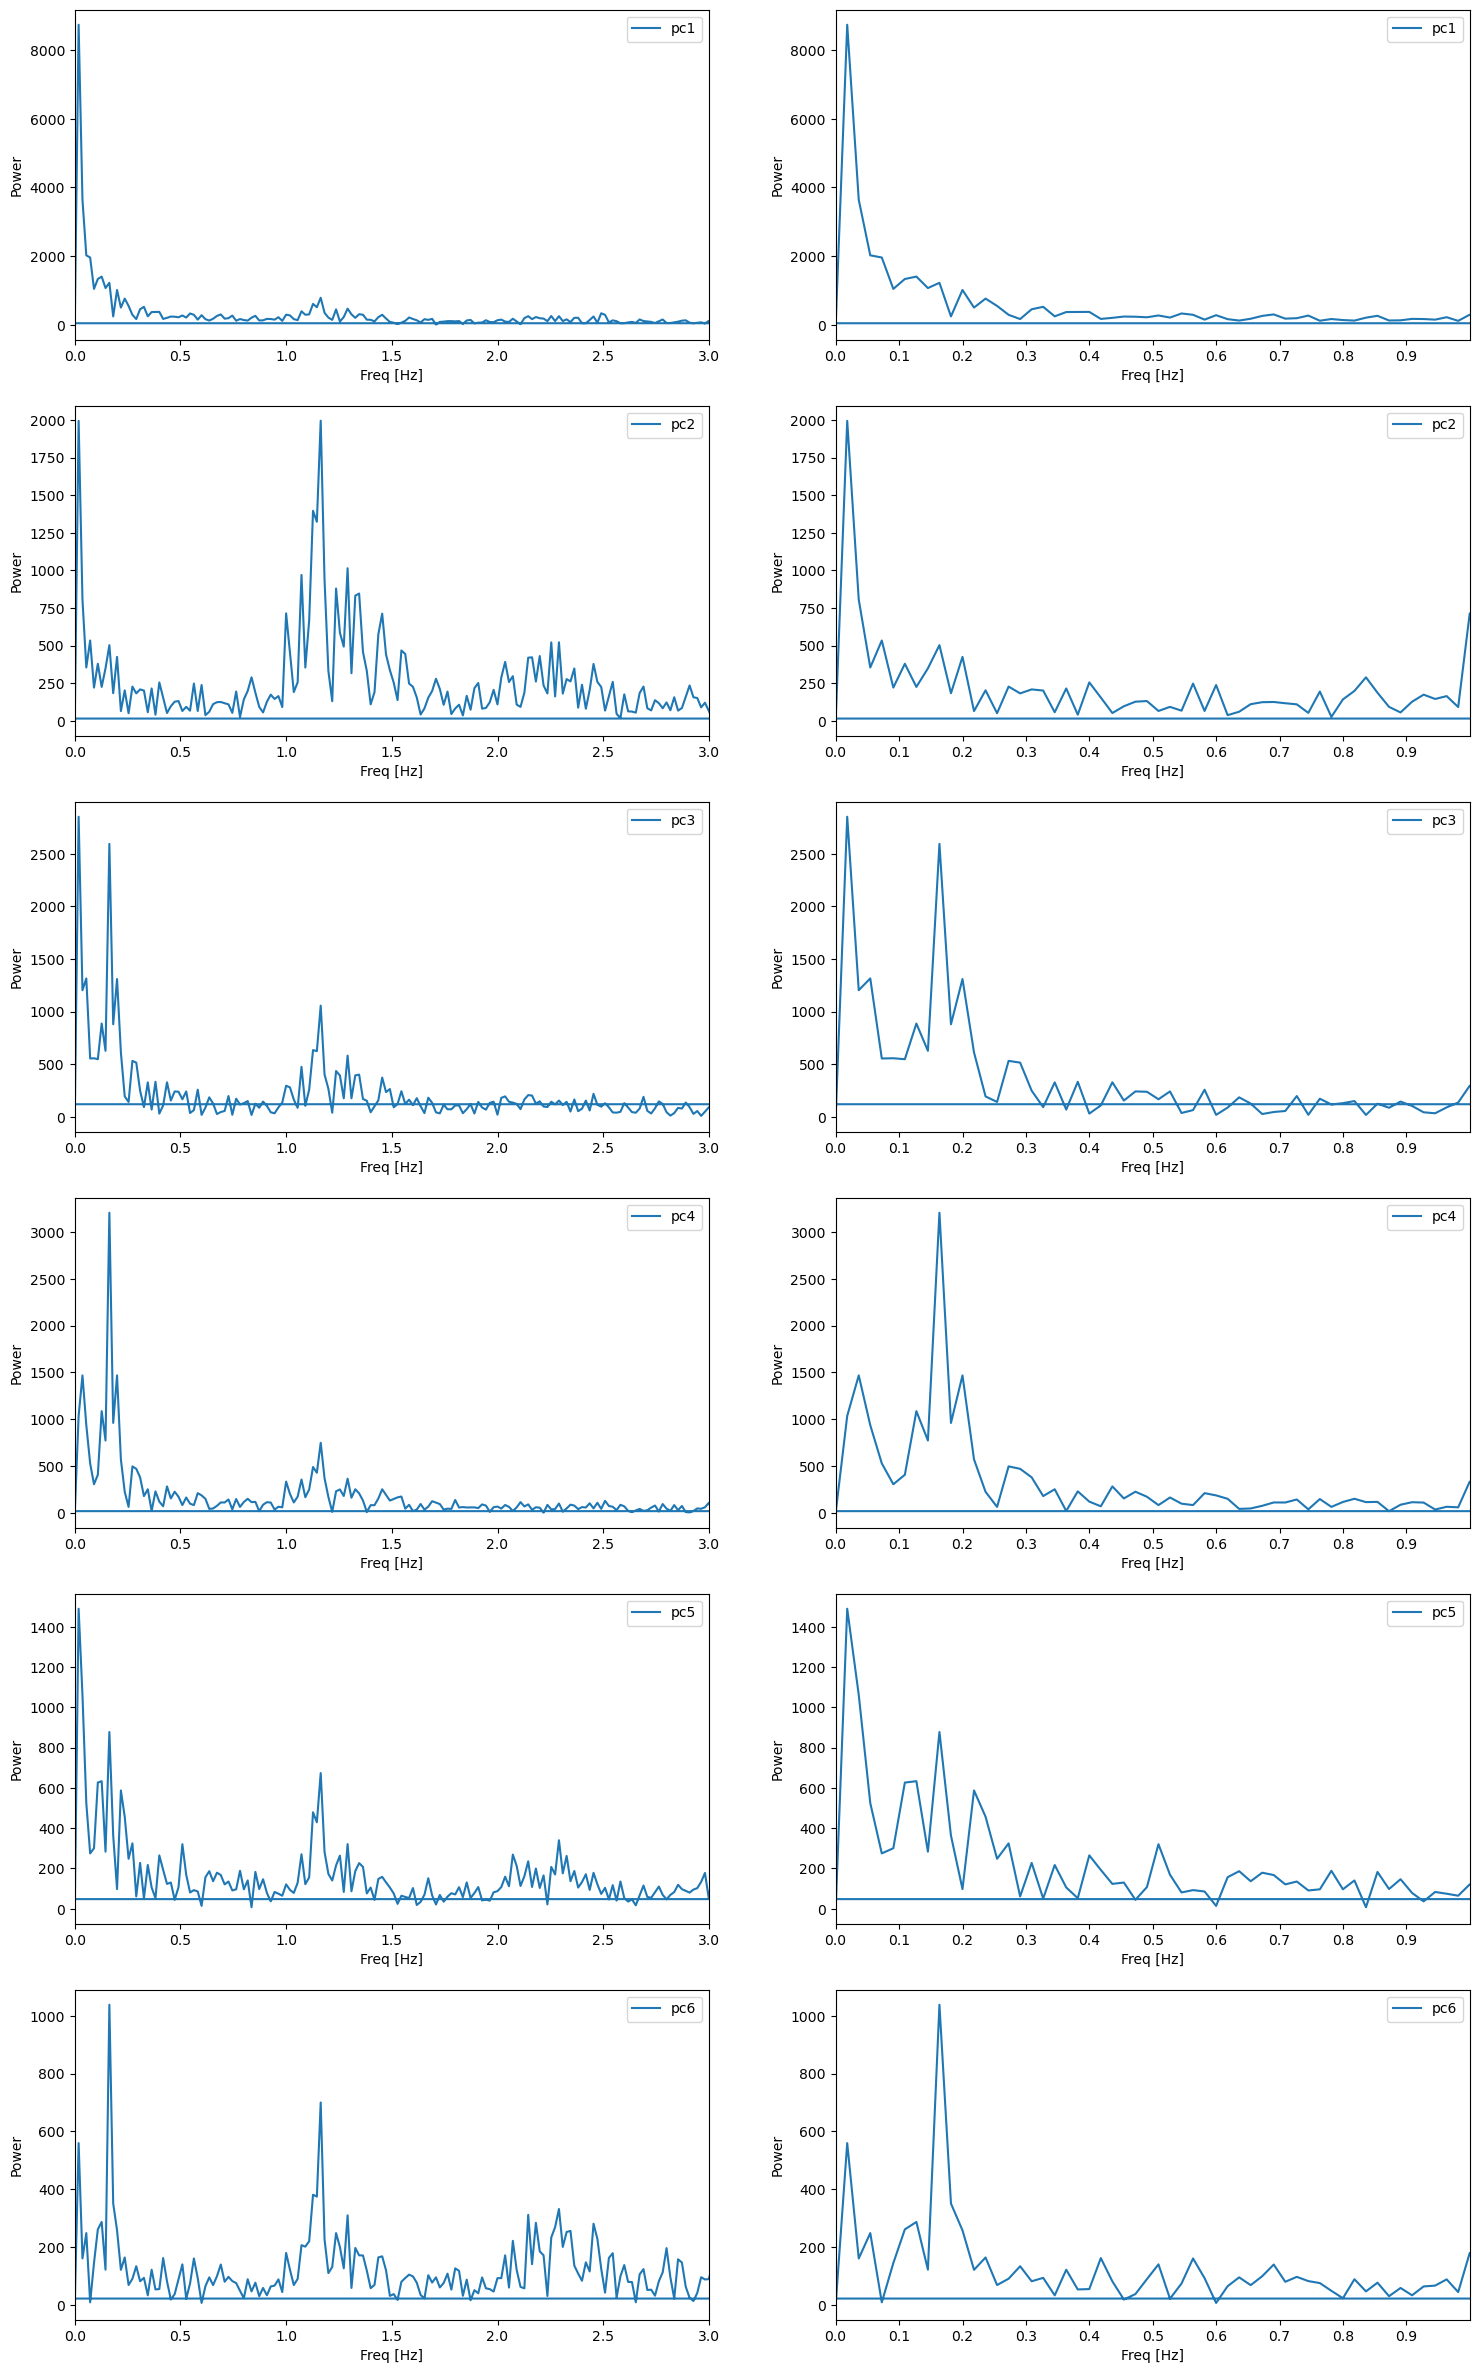

In [36]:
#Plot power spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j], label=labels[j])
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

(0.0, 1.0)

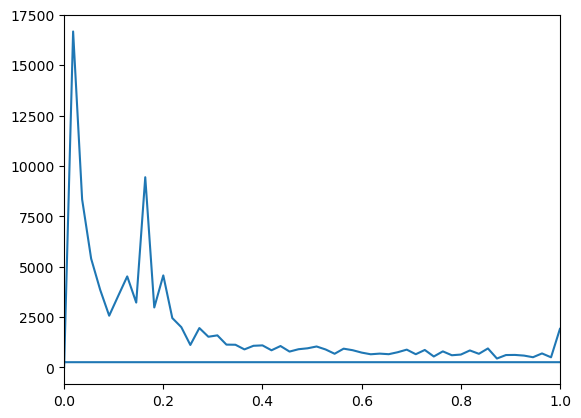

In [52]:
total_FFT = np.zeros(len(data_std['pc1']))
for i in power:
    total_FFT += i

plt.plot(sample_freq, total_FFT)
plt.xlim([0,1])

Let's now perform a wavelet transform analysis


In [70]:
pywt.dwt_max_level(len(data_std), "sym5")

10

Wavelet Bis Test

In [69]:
#Filter signal using wavelets
#We used db2, with a high decomposition level 
#as we are interested only in low frequencies but we want to exclude those near zero
#we will thus use the last three detail coefficients to
#cover ranges [0.098, 0.78125] Hz 
lvl = 0
if file_name == "center_sternum.txt":
    lvl = 10
else:
    lvl = 9
    
A10 = np.zeros((Nvar, len(data_std)+1))
for i in range(Nvar):
    coeffs = pywt.wavedec(data_std[labels[i]], "sym5", level=lvl)
    coeffs[0] = np.zeros_like(coeffs[0])
    for l in range(3, lvl+1):
        coeffs[l] = np.zeros_like(coeffs[l])
    A10[i] = pywt.waverec(coeffs, "sym5") 
    


C:\Users\enric\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


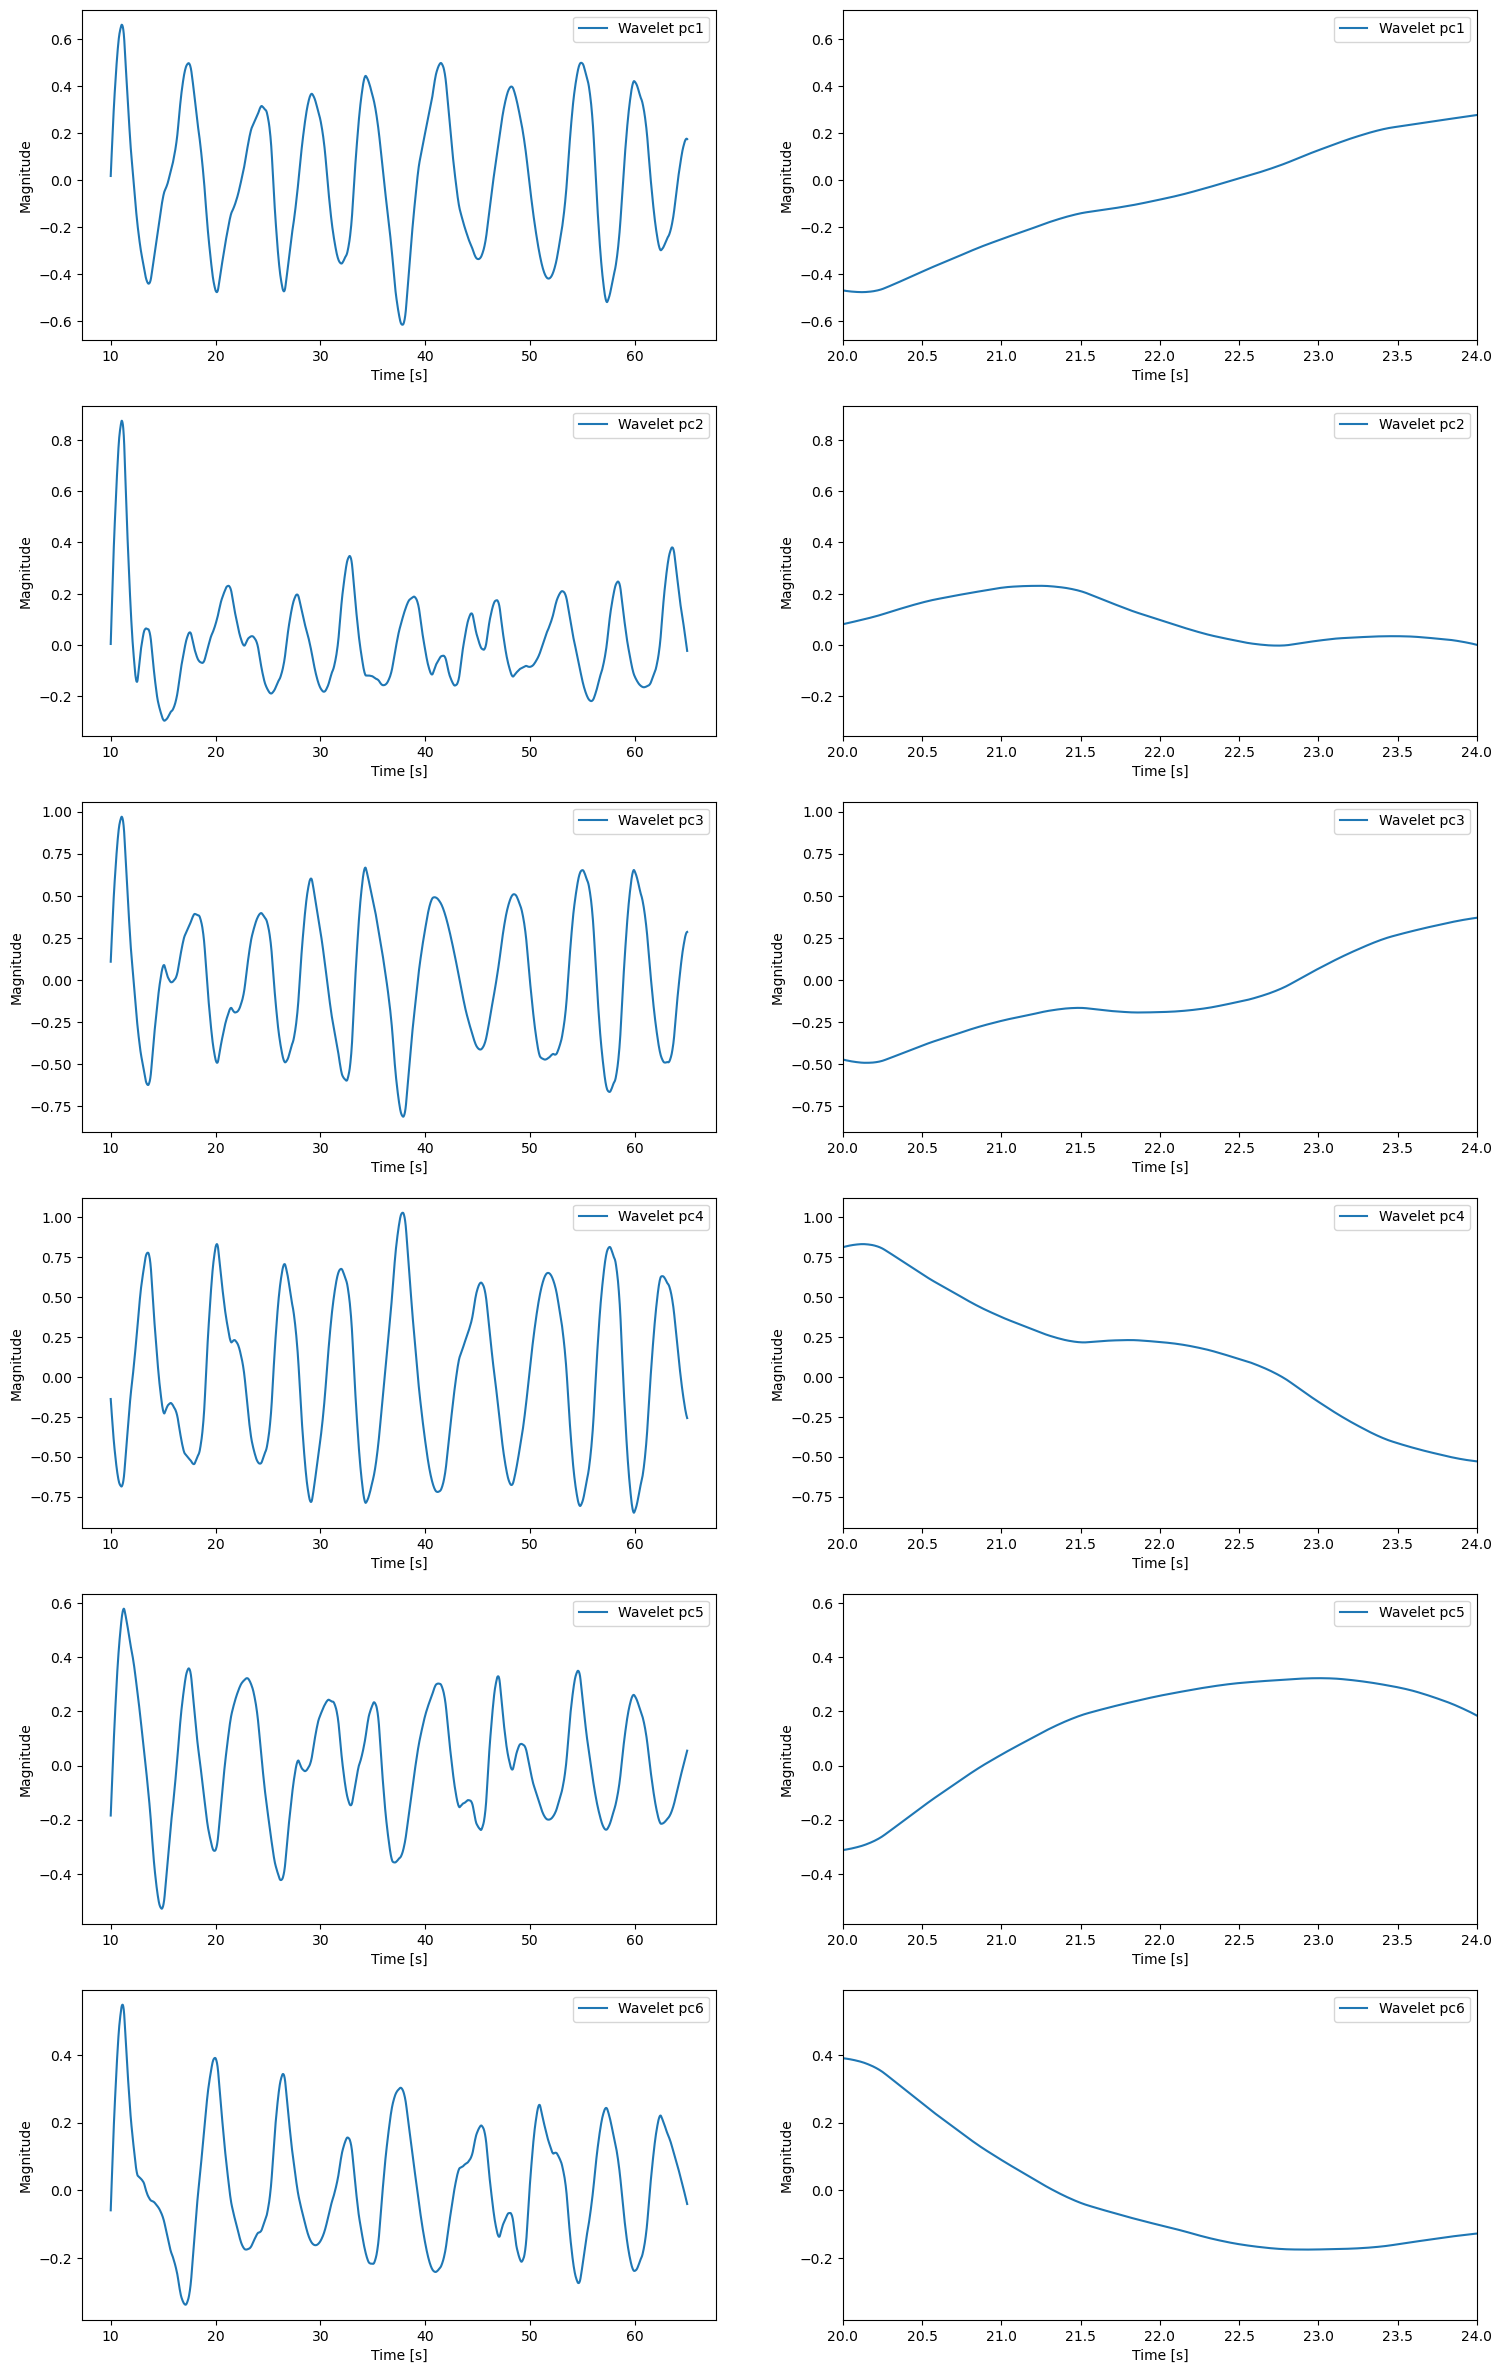

In [68]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        #axs[j][i].plot(data_std["Abs Time"], data_std[labels[j]], label=("Original "+labels[j]))
        #axs[j][i].plot(data_std["Abs Time"], filtered[j], label=("Butterworth "+labels[j]))
        #axs[j][i].plot(data_std["Abs Time"], A7[j][:-1],  label=("Butterworth+Wavelet "+labels[j]))
        axs[j][i].plot(data_std["Abs Time"], A10[j][:-1], label=("Wavelet "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([20,24])
        

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [60]:
#calculate spectrum after wavelet
sig_fft_wt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_wt[i] = fftpack.fft(A10[i][:-1])

power_wt = np.abs(sig_fft_wt)

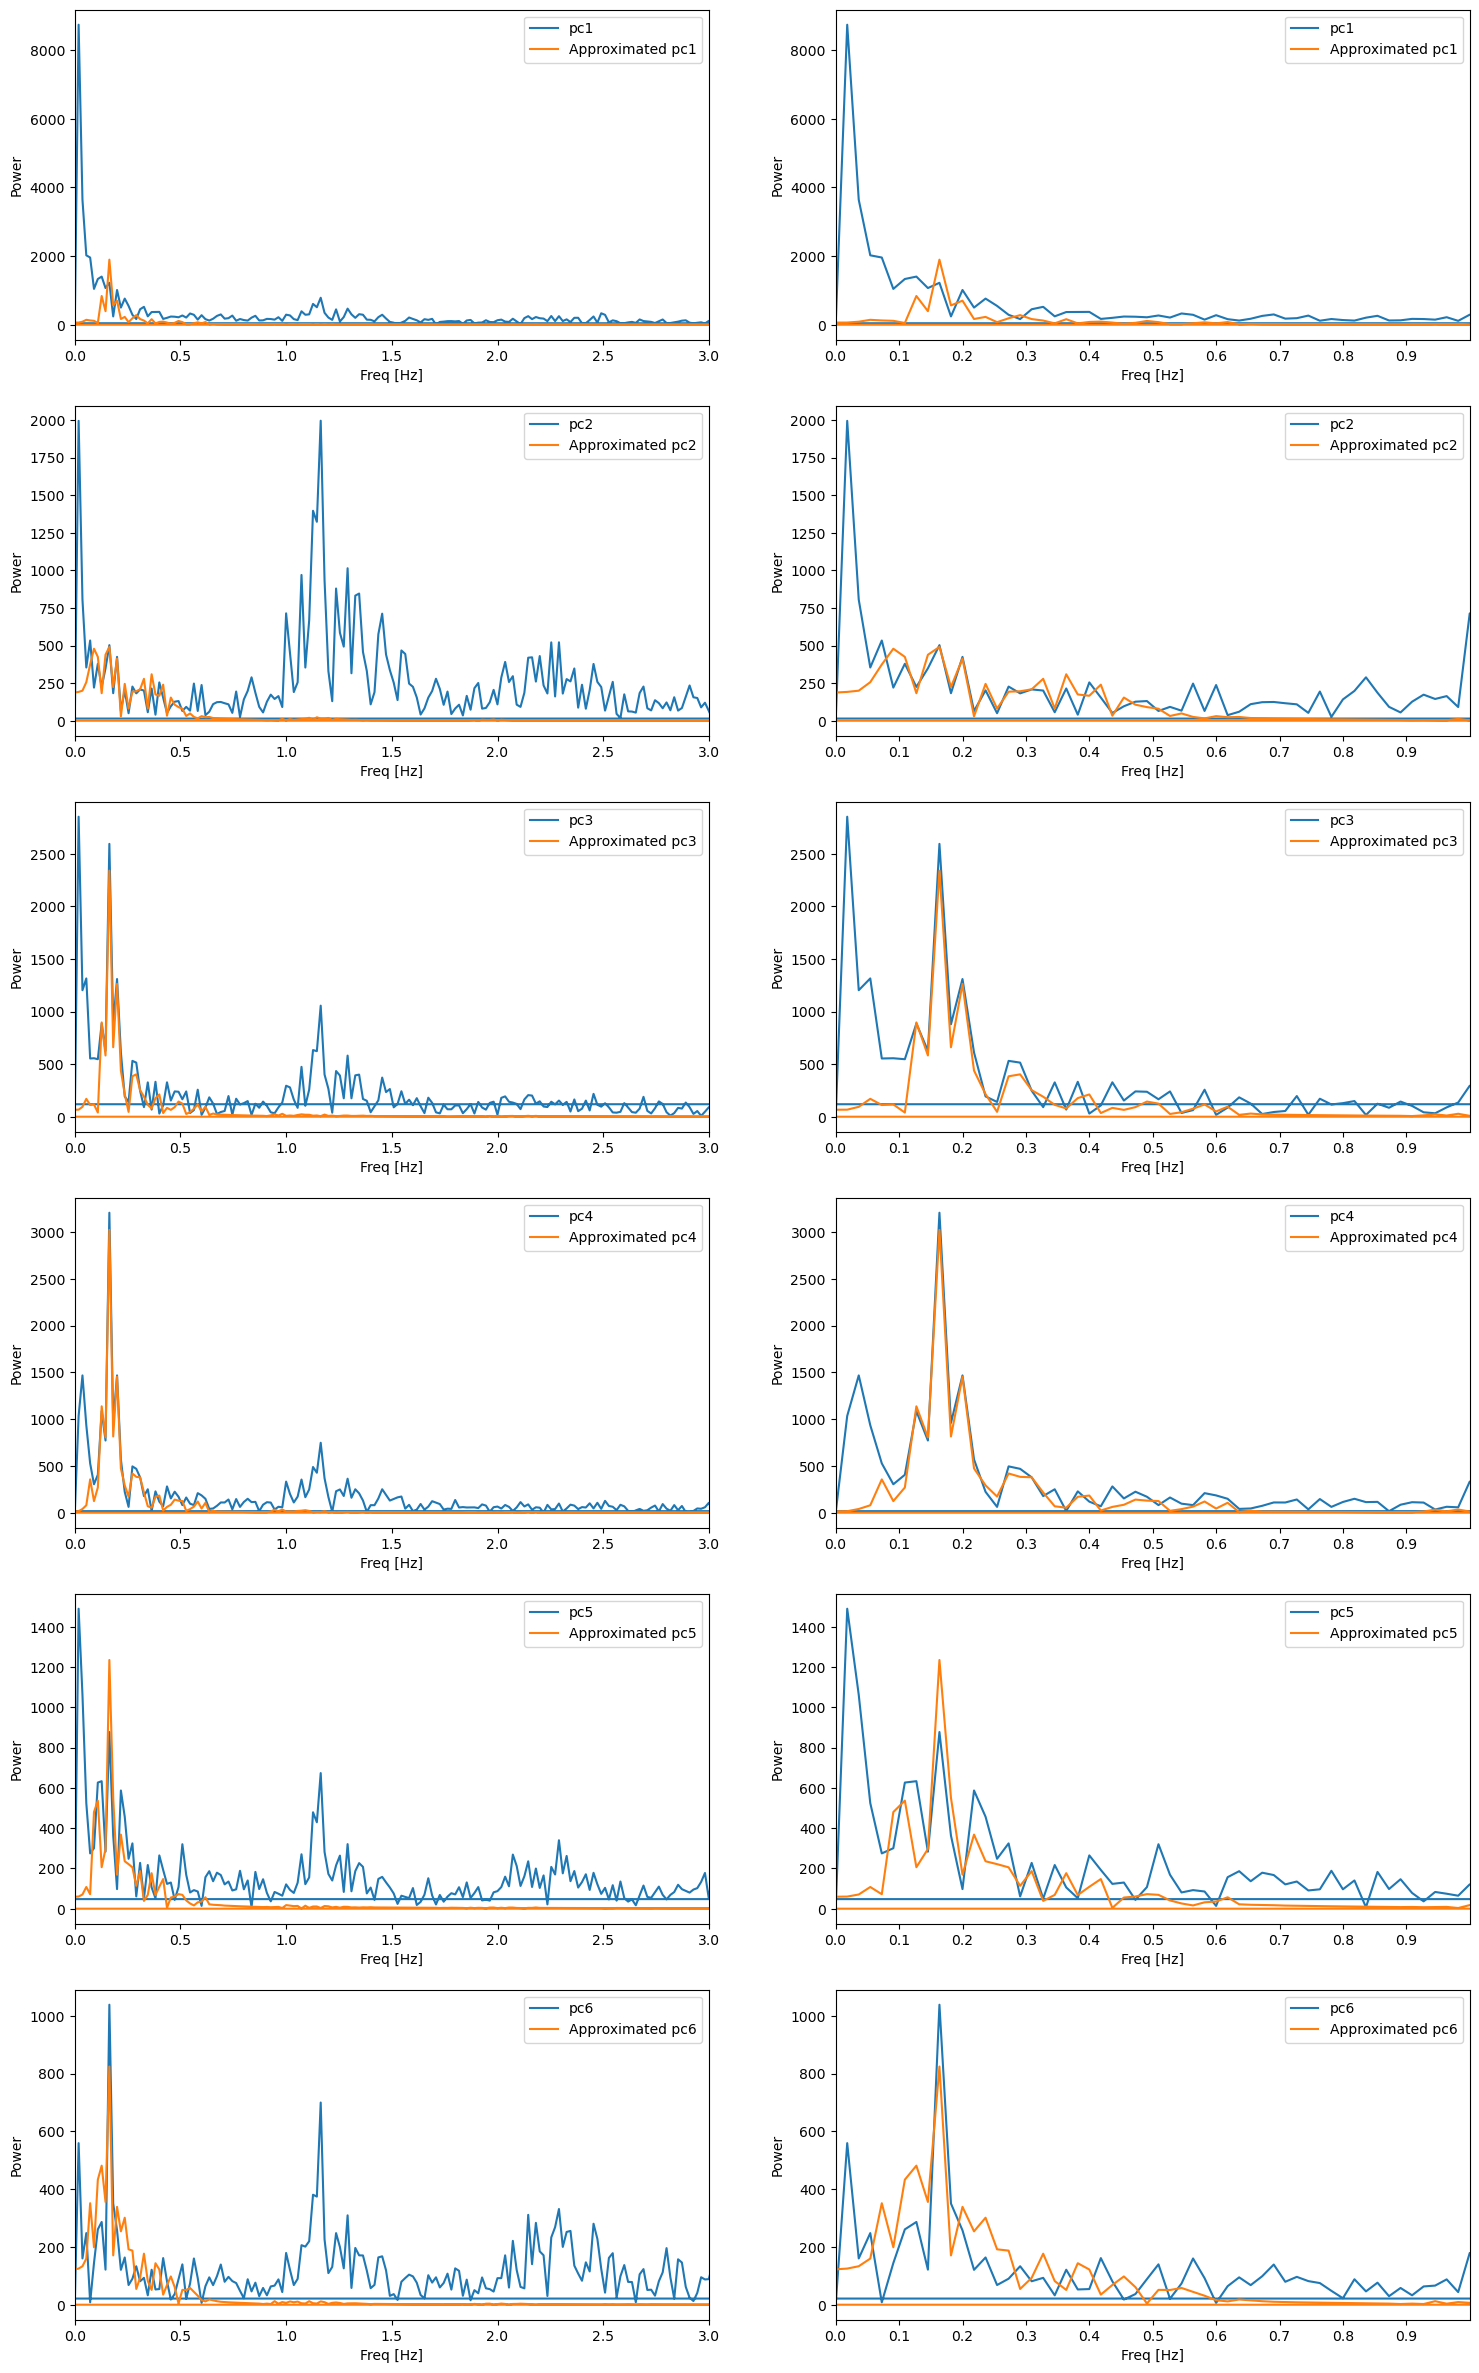

In [61]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
    
        axs[j][i].plot(sample_freq, power[j],    label=labels[j])
        axs[j][i].plot(sample_freq, power_wt[j], label=("Approximated "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

EXTRA: FILTRI DIVERSI

In [37]:
#filter signal with Butterworth bandpass filter in [0.1,0.5] Hz range

filtered = np.zeros((Nvar,len(data_std)))
sos = signal.butter(4, [0.1, 0.8], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data_std[labels[i]])
    
    

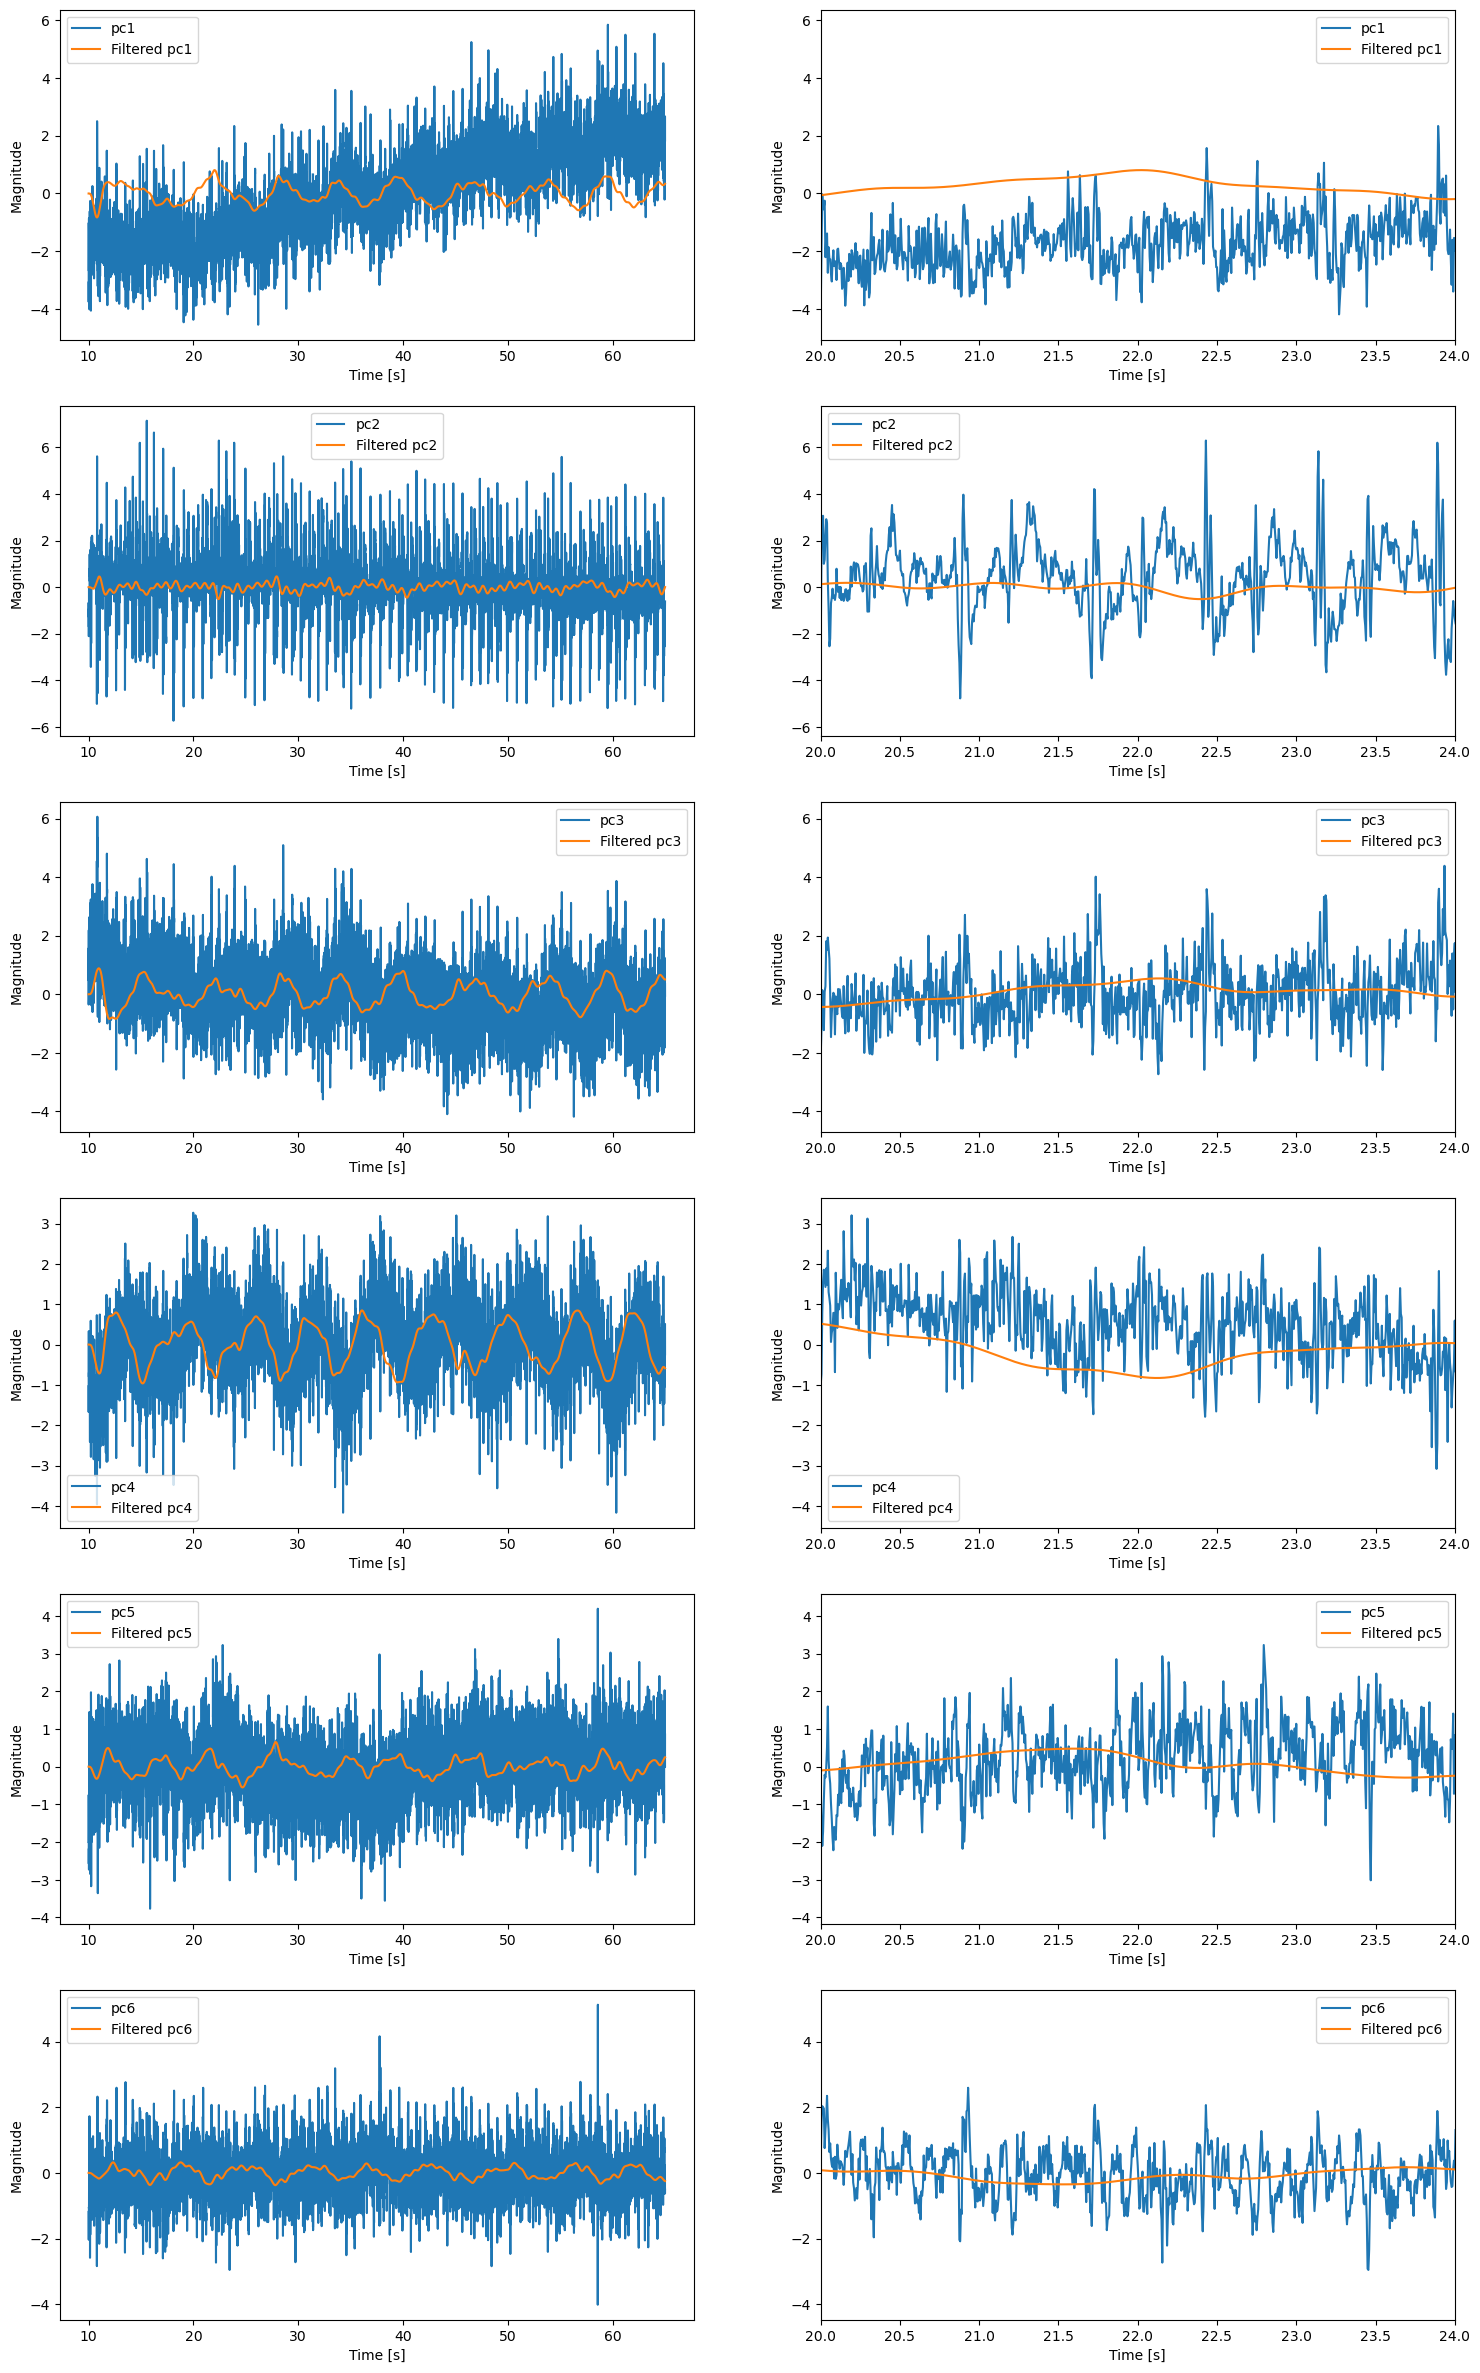

In [38]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], data_std[labels[j]], label=labels[j])
        axs[j][i].plot(data_std["Abs Time"], filtered[j],         label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([20,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [39]:
#calculate spectrum after filtering
sig_fft_filt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_filt[i] = fftpack.fft(filtered[i])

power_filt = np.abs(sig_fft_filt)

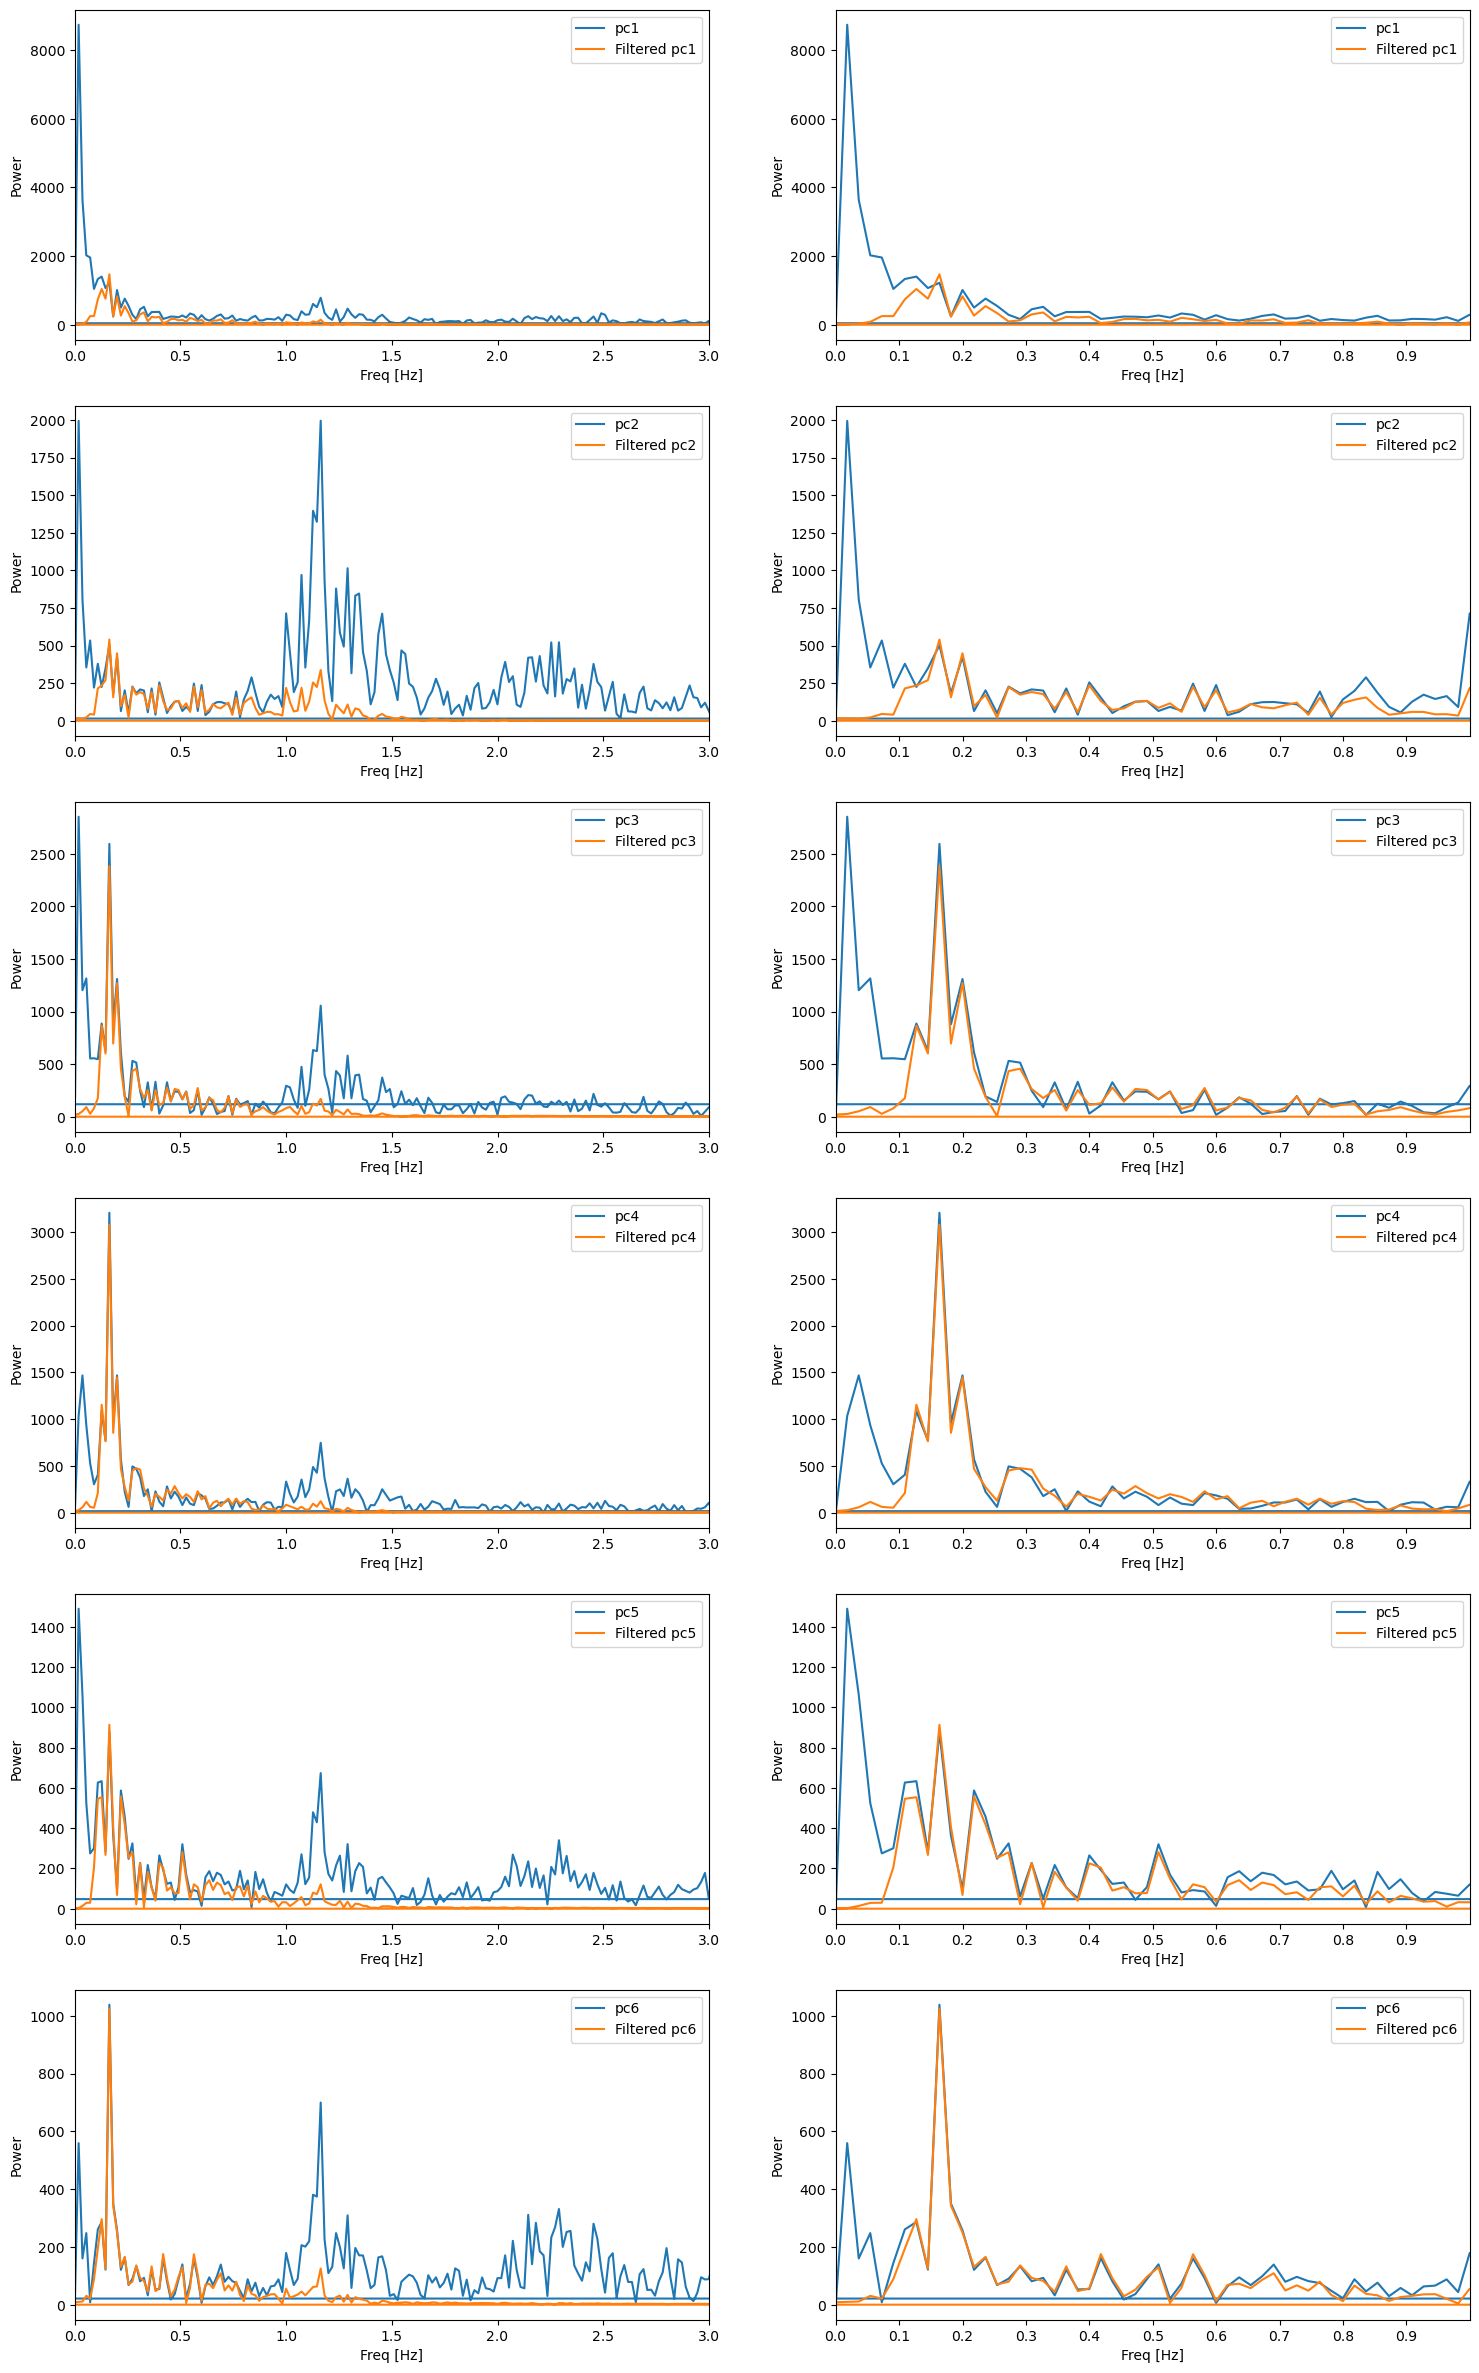

In [40]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],      label=labels[j])
        axs[j][i].plot(sample_freq, power_filt[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

In [42]:
#Filter signal using wavelets
#We used db6 as it is smooth, with a decomposition level=7 
#as we are interested only in low frequencies, and the approximate coefficients at level J
#cover ranges [0, freq/2^(J+1)], so or the last decomposition [0, 0.78125] Hz
lvl = 0
if file_name == "center_sternum.txt":
    lvl = 7
else:
    lvl = 6
    
A7 = np.zeros((Nvar, len(data_std)+1))
for i in range(Nvar):
    coeffs = pywt.wavedec(filtered[i], "db6", level=lvl)
    for l in range(1, lvl+1):
        coeffs[l] = np.zeros_like(coeffs[l])
    A7[i] = pywt.waverec(coeffs, "db6") 
    


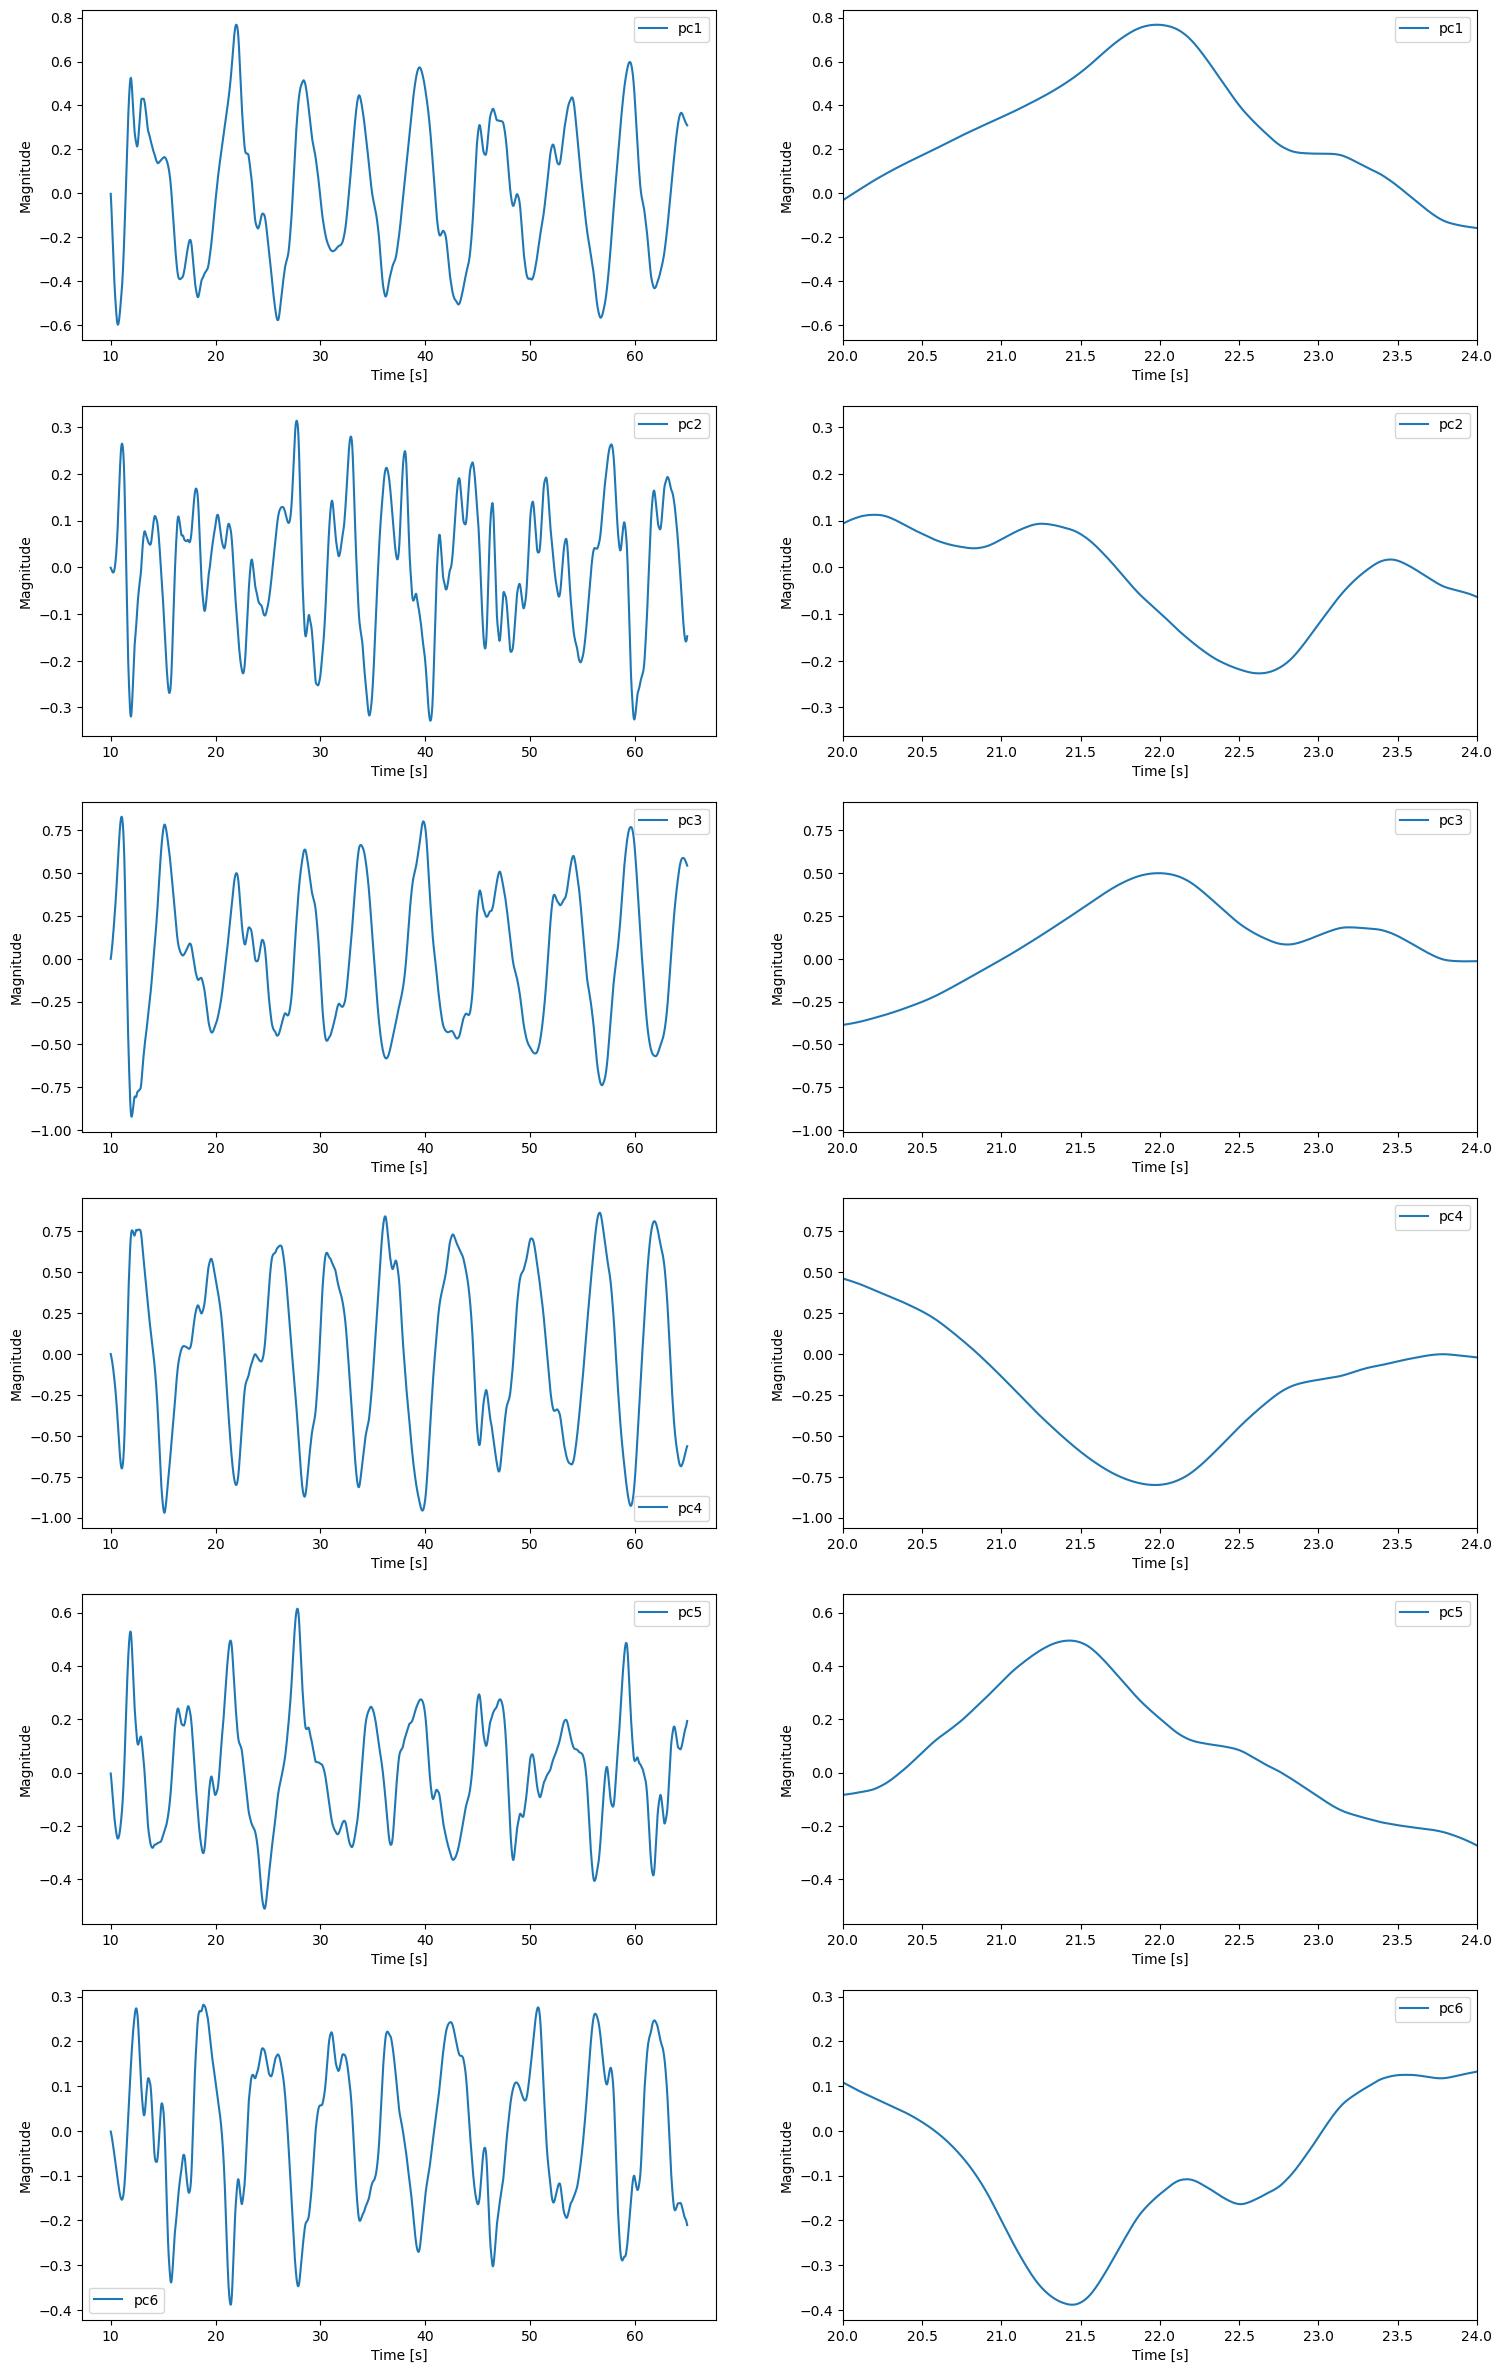

In [63]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], A7[j][:-1], label=labels[j])
        if i == 1:
            axs[j][i].set_xlim([20,24])
        

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [44]:
#calculate spectrum after wavelet
sig_fft_wt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_wt[i] = fftpack.fft(A7[i][:-1])

power_wt = np.abs(sig_fft_wt)

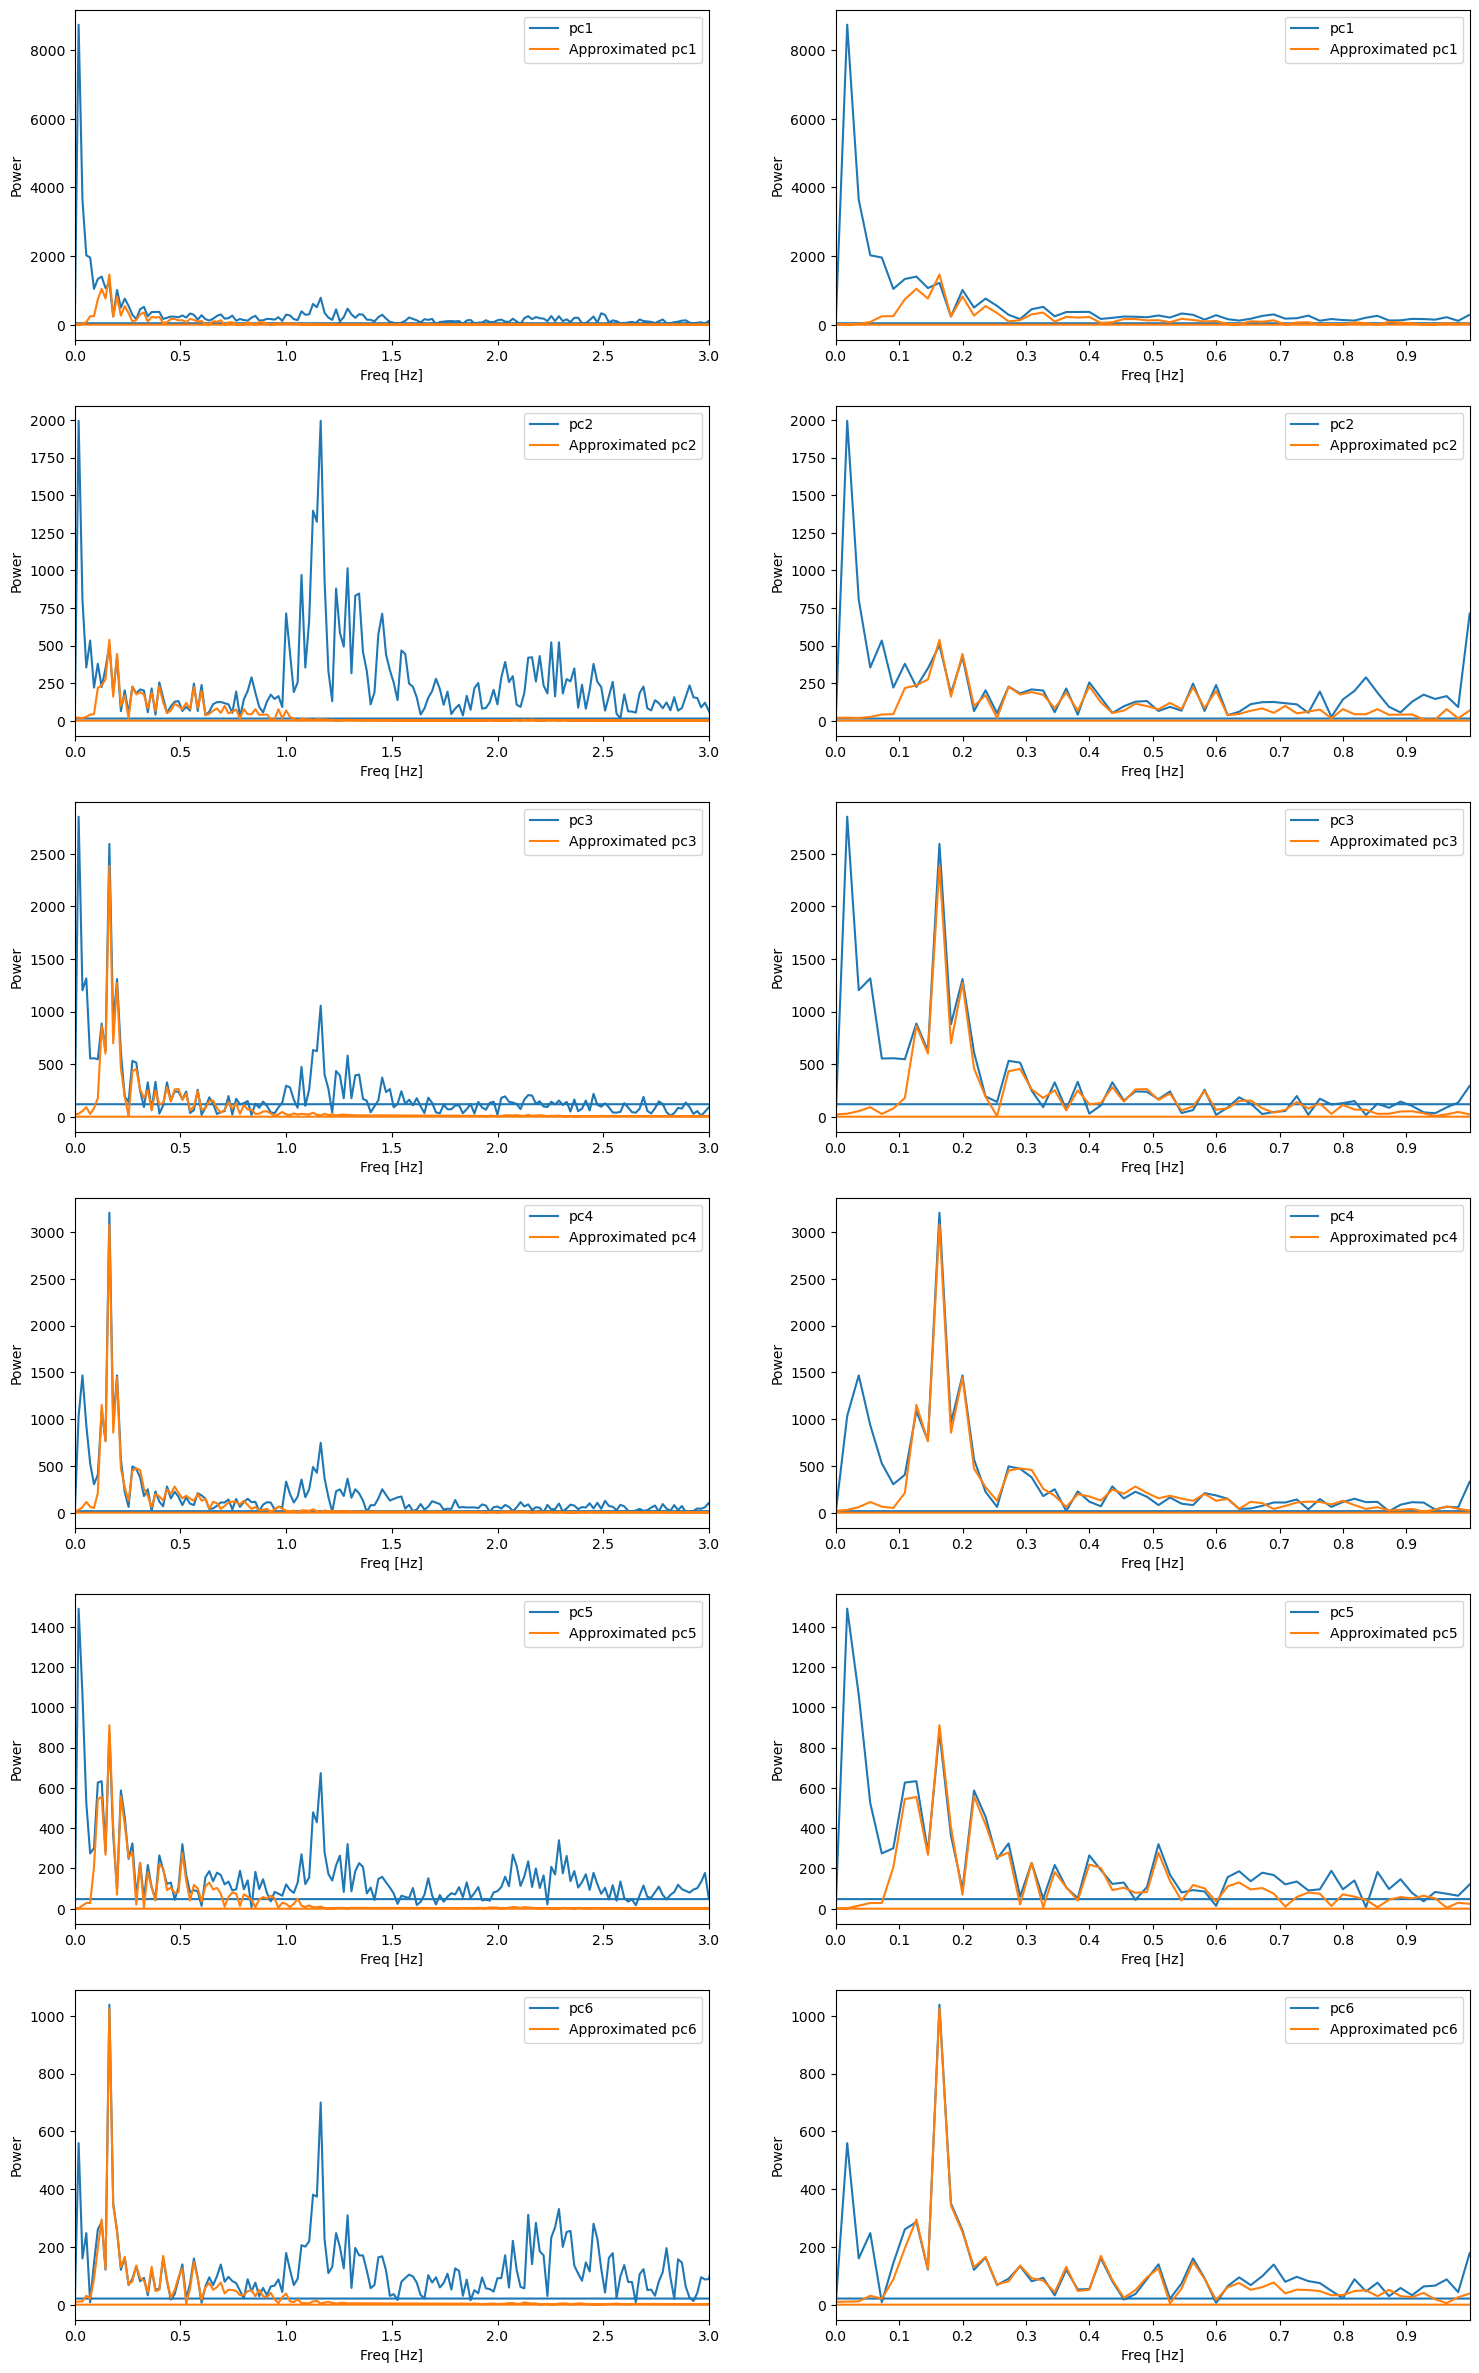

In [45]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],    label=labels[j])
        axs[j][i].plot(sample_freq, power_wt[j], label=("Approximated "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")